## <a id='top'></a>

# CSCI 3202, Fall 2020
# Assignment 2
# Due: Monday 16 November 2020 by 11:59 PM

<br> 

### Your name: Qiuyang Fu

<br> 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.integrate as integrate
import unittest



## Problem 1:  EVIU and EVPI

Suppose we have an overwhelming sense of exam déjà vu, and we're going to catch the Buff Bus again.  We want to decide at what time $d$ to go wait for it.  We decide to use the the linear loss function 

$$L(d,x)=\begin{cases} 
	2(x-d) & x\geq d \\
	4(d-x) & x <d
    	\end{cases}$$.
        
As in the exam, we model the Buff Bus arrival times as an exponential random variable $X$ that arrives on average once per hour, so they have probability density function of $f(x)=e^{-x}$ for $x>0$ (note: this has mean of $E_X[x]=1$).

The result from the exam was that the *expected loss* of the decision $d$ was:
$$E_X[L(d,x)] = \int_0^d 4(d-x)e^{-x}\, dx + \int_d^\infty 2(x-d)e^{-x}\, dx$$

...we maybe tried to avoid doing that integral and reasoned through it, because often such an integral is messy and may require numerical methods.


### (1a)  A Loss function:

Create a `ExpectedLoss` object or function that takes as input 3 arguments: 
    - a decision $d$
    - a loss function $L(d,x)$
    - a probability density $f(x)$

and returns the value of $$E_X[L(d,x)]=\int_{-\infty}^\infty L(d,x) f(x) \, dx$$.

Inside your function, you can and should use the scipy.integrate function with documentation: 
https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html.



In [2]:
def loss_fn(x, d):
    if x<d:
      return 4*(d-x)
    else:
      return 2*(x-d)

def fx(x):
  return np.exp(-x)

def final_loss(x, d, loss_fn):
  return loss_fn(x, d)*fx(x)

def ExpectedLoss(d, loss_fn, fx):
    return integrate.quad(final_loss, 0, np.inf, args=(d, loss_fn))[0]

## (1b) A quick check:
Double check that your integrate code is working well on the infinite support of the exponential random variable.  Check that you in fact get $$E[X]=\int_0^\infty e^{-x} \, dx=1$$ from your usage of `integrate` above.

In [3]:
# integrate.quad(lambda x:np.exp(-x),0,np.inf)[0]
def loss_fn1(x,d):
  return 1
ExpectedLoss(0,loss_fn1, fx)

1.0000000000000002

## (1c) Scoring Decisions:
Our goal is typically to compare the losses of 3 decision types:
 - the decision made "ignoring uncertainty," using $d=E[X]$
 - the decision made with "perfect information", using $d=x$
 - the decision made with uncertainty to minimize loss, the Bayes' decision.
 
1. Use your function in (1a) to compute the expected loss when ignoring uncertainty.

2. Use your function in (1a) or reason to compute the expected loss with perfect information.

3. Use your function in (1a) to *plot* the expected loss for a fine grid (`linspace`) of $d$ values from 0 to 10.  Given this plot, visually estimate the optimal decision $d$ and it's expected loss.

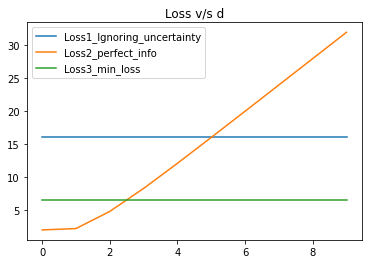

In [4]:
l1 = []
l2 = []
l3 = []

for d in np.arange(0,10,1):
  Loss1_Ignoring_uncertainty= ExpectedLoss(5, loss_fn, fx)
  l1.append(Loss1_Ignoring_uncertainty)
  Loss2_perfect_info = ExpectedLoss(d, loss_fn, fx)
  l2.append(Loss2_perfect_info)
  Loss3_min_loss = ExpectedLoss(2.5, loss_fn, fx)
  l3.append(Loss3_min_loss)

# Note: Change the functions 'loss_fn' & 'fx' defined in the starting cell for customized input

dx= [i for i in range(10)]
plt.plot(dx, l1, label='Loss1_Ignoring_uncertainty')
plt.plot(dx, l2, label='Loss2_perfect_info')
plt.plot(dx, l3, label='Loss3_min_loss')
plt.title('Loss v/s d')
plt.legend()

## (1d) Optimizing Decisions:
Since the Bayes' decision should be the minimum of the function in (1a), we can use another numeric method in Python to find it exactly!  Check out `scipy.optimize` https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html and use it to find the Bayes' decision.

For convenience, you may restructure your code in (1a) to get the loss function while only $d$ as taken as an input.

In [5]:
from scipy.optimize import minimize_scalar
res = minimize_scalar(lambda x: ExpectedLoss(x,loss_fn,fx), method='brent')
res.x

0.40545849006734413

## (1e) Bigger Losses
$$L_l(d,x)=\begin{cases} 
	20(d-x) & x \leq d \\
	200+20(d-x) & x> d \\		
	\end{cases}$$.
    
Consider instead the loss function above, which contains a large jump at $x=d$.  Use your `ExpectedLoss` and/or `optimize` routines to find the Bayes' decision for the bus-waiting problem in this case, where a large amount of utility is lost as soon as $x>d$ (or we miss the bus).  Does your result here seem intuitive, given the Bayes' decision in parts (1c/1d)?

In [6]:
def big_loss_fn(x, d):
    if x<=d:
      return 20*(d-x)
    else:
      return 200 + 20*(d-x)
res_big = minimize_scalar(lambda x: ExpectedLoss(x,big_loss_fn,fx), method='brent')
res_big.x

2.3031347714552965


## Problem 2:  Bayesian network to model heart disease

The following Bayesian network is based loosely on a study that examined heart disease risk factors in 167 elderly individuals in South Carolina.  Note that this figure uses Y and N to represent Yes and No, whereas in class we used the equivalent T and F to represent True and False Boolean values.

<img src="http://www.cs.colorado.edu/~tonyewong/home/resources/hw05_bayesnet_heartdisease.png" style="width: 650px;"/>

<a id='p1a'></a>

### (2a) 

Create a `BayesNet` object to model this.  Below are the codes for the (conditional) probability `P` function and `BayesNode` class as well, that we used in class on Monday (9 March) to represent the variable nodes and calculate probabilities. You can code this however you want, subject to the following constraints:
1. the nodes are represented using the `BayesNode` class and can work with the `P` function for probabilities,
1. your `BayesNet` structure keeps track of which nodes are in the Bayes net, as well as
1. which nodes are the parents/children of which other nodes.

Some *suggested* skeleton codes for a class structure are given. You are free and encouraged to use the code from our in-class notebooks on Bayes Nets and Markov Models. The point of this exercise is to make sure you understand the example from class. The suggestions for methods to implement are in view of the fact that we will need to calculate some probabilities, which is going to require us to `find_node`s and `find_values` that nodes can take on.

In [7]:
## For the sake of brevity...
T, F = True, False

## From class:
def P(var, value, evidence={}):
    '''The probability distribution for P(var | evidence), 
    when all parent variables are known (in evidence)'''
    if len(var.parents)==1:
        # only one parent
        row = evidence[var.parents[0]]
    else:
        # multiple parents
        row = tuple(evidence[parent] for parent in var.parents)
    return var.cpt[row] if value else 1-var.cpt[row]

## Also from class:
class BayesNode:
    
    def __init__(self, name, parents, values, cpt):
        if isinstance(parents, str):
            parents = parents.split()
            
        if len(parents)==0:
            # if no parents, empty dict key for cpt
            cpt = {(): cpt}
        elif isinstance(cpt, dict):
            # if there is only one parent, only one tuple argument
            if cpt and isinstance(list(cpt.keys())[0], bool):
                cpt = {(v): p for v, p in cpt.items()}

        self.variable = name
        self.parents = parents
        self.cpt = cpt
        self.values = values
        self.children = []
        
    def __repr__(self):
        return repr((self.variable, ' '.join(self.parents)))    

    
##===============================================##
## Suggested codes for a BayesNet class ##
##===============================================##

class BayesNet:
    '''Bayesian network containing only boolean-variable nodes.'''

    def __init__(self, nodes):
        '''Initialize the Bayes net by adding each of the nodes,
        which should be a list BayesNode class objects ordered
        from parents to children (`top` to `bottom`, from causes
        to effects)'''
        
        # your code goes here...
        self.network = []
        self.variables = []
        
        for node in nodes:
            self.add(node)
                
    def add(self, node):
        '''Add a new BayesNode to the BayesNet. The parents should all
        already be in the net, and the variable itself should not be'''
        assert node.variable not in self.variables
        #assert all((parent in self.variables) for parent in node.parents)
        
        self.network.append(node)
        self.variables.append(node.variable)
        
            
    def find_node(self, var):
        '''Find and return the BayesNode in the net with name `var`'''
        
        # your code goes here...
        for node in self.network:
            if node.variable == var:
                return node
        print('Variable not in Network.')
        return None
        

        
    def find_values(self, var):
        '''Return the set of possible values for variable `var`'''
        
        # your code goes here...
        node = self.find_node(var)
        return node.values
        

    
    def __repr__(self):
        return 'BayesNet({})'.format(self.network) # changed from self.nodes

In [8]:
# Create a Bayes net with those nodes and connections
#First is Mod. Exercise, ME.
ME = BayesNode('ME', '', [T,F], 0.5)
#Then is Smoking, SM.
SM = BayesNode('SM', '', [T,F], 0.2)
#Then is Atherosclrosis, AT.
AT = BayesNode('AT', '', [T,F], 0.53)
#Then Family History, FH.
FH = BayesNode('FH', '', [T,F], 0.15)
#High Blood Pressure, HBP
HBP = BayesNode('HBP', ['SM', 'ME'], [T,F], {(T, T): 0.6, (T, F): 0.72, (F, T): 0.33, (F, F): 0.51})
#Heart Disease, HD
HD = BayesNode('HD', ['AT', 'HBP', 'FH'], [T,F], {(T, T, T): 0.92, (T, T, F): 0.91, (T, F, T): 0.81, (T, F, F): 0.77, (F, T, T): 0.75, (F, T, F): 0.69, (F, F, T): 0.38, (F, F, F): 0.23})
#Rapid Heartbeats, RAPHB
RAPHB = BayesNode('RAPHB', 'HD', [T,F], {T: 0.99, F: 0.3})
#Angina Pectoris, ANGPT
ANGPT = BayesNode('ANGPT', 'HD', [T,F], {T: 0.85, F: 0.4})

#Creating the BayesNet of bnHeart with these values.
bnModel = BayesNet([SM, ME, HBP, AT, FH, HD, ANGPT, RAPHB])

In [9]:
class Tests_Problem2(unittest.TestCase):
    def setUp(self):
        self.p1 = BayesNode('p1', '', [T,F], 0.3)
        self.p2 = BayesNode('p2', '', [T,F], 0.6)
        self.c  = BayesNode('c', ['p1', 'p2'], [T,F], {(T,T):0.1, (T,F):0.2, (F,T):0.3, (F,F):0.4})
    def test_onenode(self):
        self.assertEqual(P(self.p1, T), 0.3)
    def test_twonode(self):
        self.assertEqual(P(self.c, F, {'p1':T, 'p2':F}), 0.8)

In [10]:
tests_to_run = unittest.TestSuite()
tests_to_run.addTest(Tests_Problem2("test_onenode"))
tests_to_run.addTest(Tests_Problem2("test_twonode"))
unittest.TextTestRunner().run(tests_to_run)

..
----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>


### (2b)

Craft a function `get_prob(X, e, bn)` to return the **normalized** probability distribution of variable `X` in Bayes net `bn`, given the evidence `e`.  That is, return $P(X \mid e)$. The arguments are:
* `X` is some representation of the variable you are querying the probability distribution of. Either a string (the variable name from the `BayesNode` or a `BayesNode` object itself are good options.
* `e` is some representation of the evidence your probability is conditioned on. When given an empty argument (or `None`) for `e`, `get_prob` should return the marginal distribution $P(X)$.
* `bn` is your `BayesNet` object.

You may do this using the `enumeration` algorithm from class (pseudocode is in the book), or by brute force (i.e., use a few `for` loops). Either way, you should be using your `BayesNet` object to keep track of all the nodes and relationships between nodes so your `get_prob` function knows these things.

Suggest implementation is below, where we use the `PDF_discrete` class and its associated functions as we did in the Bayes Nets in class notebook.

In [11]:
#solution
import math
class PDF_discrete:
    '''Define a discrete probability distribution function.'''

    def __init__(self, varname='?', freqs=None):
        '''Create a dictionary of values - frequency pairs,
        then normalize the distribution to sum to 1.'''
        self.prob = {}
        self.varname = varname
        self.values = []
        if freqs:
            for (v, p) in freqs.items():
                self[v] = p
        self.normalize()

    def __getitem__(self, value):
        '''Given a value, return P[value]'''
        try:
            return self.prob[value]
        except KeyError:
            return 0

    def __setitem__(self, value, p):
        '''Set P[value] = p, input argument if '''
        if value not in self.values:
            self.values.append(value)
        self.prob[value] = p

    def normalize(self):
        '''Normalize the probability distribution and return it.
        If the sum of PDF values is 0, then return a 0'''
        total = sum(self.prob.values())
        if not math.isclose(total, 1.0):
            for value in self.prob:
                self.prob[value] /= total
        return self
    
def extend(s, var, val):
    """Copy the substitution s and extend it by setting var to val; return copy."""
    s2 = s.copy()
    s2[var] = val
    return s2

def enumerate_all(variables, e, bn):
    '''Return the sum of those entries in P(variables | e{others})
    consistent with e, where P is the joint distribution represented
    by bn, and e{others} means e restricted to bn's other variables
    (the ones other than variables). Parents must precede children in variables.'''
    if not variables:
        return 1.0
    Y, rest = variables[0], variables[1:]
    Ynode = bn.find_node(Y)
    if Y in e:
        # Y in evidence, so we know its value and just multiply
        return P(Ynode, e[Y], e) * enumerate_all(rest, e, bn)
    else:
        # Y not in evidence so we have to sum (Law of Total Prob.)    
        return sum(P(Ynode, y, e) * enumerate_all(rest, extend(e, Y, y), bn)
                   for y in bn.find_values(Y))

#Writing my Get Probability Function here.
def get_prob(X, e, bn):
    #We need to return the conditional probability distribution from our bn (Bayes Net)
    #of variable X, with the evidence (e).
    #Instantiate object of class PDF_Discrete.
    Disc = PDF_discrete(X)
    #For i in Bayes Net Values of X
    for i in bn.find_values(X):
        #Use enumerate function here to find Distribution
        Disc[i] = enumerate_all(bn.variables, extend(e, X, i), bn)
    #Return normalized
    return Disc.normalize()

### (2c)
Use your `get_prob` function to calculate the following probabilities. Print them to the screen and compare to the original Bayes net figure given to make sure the output passes these "unit tests".

1. The marginal probability of `Family History` is $P(FH=T)=0.15$
2. The probability of *not* experiencing `Angina Pectoris`, given `Heart Disease` is observed, is $P(Ang=F \mid HD=T)=1-0.85=0.15$
3. The probability of `High Blood Pressure`, given a person does `Smoke and/or use Alcohol` but does not get `Moderate Exercise`, is $P(HBP=T \mid Sm=T, ME=F)=0.72$
4. The probability of an arbitrary individual having Heart Disease,  P(HD=T)P(HD=T)
5. The probability that an individual does not have Heart Disease, given that Rapid Heartbeat was observed,  P(HD=F∣Rapid=T)P(HD=F∣Rapid=T)
6. The probability that an individual is a `Smoker/Alcohol User` if they have `Heart Disease`, $P(Sm=T \mid HD=T)$
7. How would you expect the probability in 6. to change if you also know the individual has `High Blood Pressure`?  Verify your hypothesis by calculating the relevant probability.

In [12]:
ME = BayesNode('ME', '', [T,F], 0.50)
Sm = BayesNode('Sm', '', [T,F], 0.20)
HBP = BayesNode('HBP', ['Sm','ME'], [T,F], {(T,T):0.60, (T,F):0.72, (F,T):0.33, (F,F):0.51})

Ath = BayesNode('Ath', '', [T,F], 0.53)
FH = BayesNode('FH', '',[T,F], 0.15)

HD = BayesNode('HD', ['Ath', 'HBP', 'FH'], [T,F], {(T,T,T):0.92, (T,T,F):0.91, (T,F,T):0.81, (T,F,F):0.77, (F,T,T):0.75, (F,T,F):0.69, (F,F,T):0.38, (F,F,F):0.23}) 

Ang = BayesNode('Ang', ['HD'], [T,F],{(T): 0.85, (F): 0.40})
Rapid = BayesNode('Rapid', ['HD'], [T,F],{(T): 0.99, (F): 0.30})

bn = BayesNet([Sm, ME, HBP, Ath, FH, HD, Ang, Rapid])

FH = get_prob(X = 'FH', e = {}, bn = bnModel)
print('1. P(FH) = {}'.format(FH.prob))
print('-------------------')
APHD = get_prob(X = 'ANGPT', e = {'HD' : T}, bn = bnModel)
print('2. P(ANGPT = F| HD = T) = {}'.format(APHD.prob[0]))
print('-------------------')
HBP = get_prob(X = 'HBP', e={'SM' : T, 'ME' : F}, bn = bnModel)
print('3. P(HBP = T | SM = T, ME = F) = {}'.format(HBP.prob[1]))
print('-------------------')
HD = get_prob(X = 'HD', e = {}, bn = bnModel)
print('4. P(HD) = {}'.format(HD.prob[1]))
print('So Probability of it happening is approximately {}'.format(round(HD.prob[1], 2)))
print('-------------------')
HDRT = get_prob(X = 'HD', e = {'RAPHB' : T}, bn = bnModel)
print('5. P(HD = F | RAPHB = T) = {}'.format(HDRT.prob))
print('So Probability of it happening is approximately {}'.format(round(HDRT.prob[0], 2)))
print('-------------------')
HDSMA = get_prob(X = 'SM', e = {'HD' : T}, bn = bnModel)
print('6. P(SM | HD = T) = {}'.format(HDSMA.prob))
print('So Probability of it happening is approximately {}'.format(round(HDSMA.prob[1], 2)))
print('-------------------')
HBPSMA = get_prob(X= 'SM', e = {'HD' : T, 'HBP' : T}, bn = bnModel)
print('7. P(SM | HD = T, HBP = T) = {}'.format(HBPSMA.prob))
print('So Probability of it happening is approximately {}'.format(round(HBPSMA.prob[1], 2)))
print('-------------------')
# print('1. Prob(FH = T) = ',get_prob(FH, None, bn)[T])
# print('2. Prob(Ang=F | HD = T)=', get_prob(Ang, {'HD': T}, bn)[F])
# print('3. Prob(HBP=T | Sm=T, ME=F) = ', get_prob(HBP, {'Sm': T, 'ME': F}, bn)[T])
# print('4. P(HD)=',get_prob(HD, None, bn)[T])
# print('5. P(HD=F | Rapid=T)=',get_prob(HD, {'Rapid': T}, bn)[F])
# print('6. P(Sm | HD=T)=',get_prob(Sm, {'HD': T}, bn)[T])
# print('7. P(Sm | HBP=T, HD=T)=',get_prob(Sm, {'HBP': T, 'HD': T}, bn)[T])

1. P(FH) = {True: 0.15, False: 0.85}
-------------------
2. P(ANGPT = F| HD = T) = 0.15000000000000002
-------------------
3. P(HBP = T | SM = T, ME = F) = 0.7199999999999999
-------------------
4. P(HD) = 0.6617765600000001
So Probability of it happening is approximately 0.66
-------------------
5. P(HD = F | RAPHB = T) = {True: 0.865895362727999, False: 0.13410463727200098}
So Probability of it happening is approximately 0.13
-------------------
6. P(SM | HD = T) = {True: 0.2163440784303391, False: 0.7836559215696609}
So Probability of it happening is approximately 0.22
-------------------
7. P(SM | HD = T, HBP = T) = {True: 0.28205128205128205, False: 0.717948717948718}
So Probability of it happening is approximately 0.28
-------------------


### (2d)
Rather than exact calculations, we can also *simulate* on a Bayesian Network.  Simulate 10000 hypothetical elderly individuals from South Carolina on the given network.  Using logicals, compute the probabilities in numbers (6.) and (7.) of part (2c) and verify that they are approximately equivalent.

No API is required here, but your final result should print the empirical (simulated) probabilities next to the exact theoretical results for these two outcomes from (2c).

In [13]:
#Recommended simulation structure:
#Set up same BayesNodes or Conditional Probability Tables as in (2a)

#For 10000 samples...

    #Randomly sample variables from top-to-bottom on the network, where children probabilities depend on parent values

    #Save them all in one large Data frame or array

In [14]:
# CPT- Conditional probability table generation
import pandas as pd
import random 

data = {
  'sm': [],
	'me': [],
	'hbp': [],
	'ath': [],
  'fh': [],
  'hd': [],
  'ap': [],
  'rp': []
    }
df_health = pd.DataFrame(data)    
n = 10000
for i in range(10000):
  ch = "TF"
  sm = random.choices(ch, weights=(0.2*n, 0.8*n), k=1)[0]
  me = random.choices(ch, weights=(0.5*n, 0.5*n), k=1)[0]
  
  if (sm=='T' and me=='T'):prob= 0.6
  elif(sm=='T' and me=='F'):prob=0.72
  elif(sm=='F' and me=='T'):prob=0.33
  else:prob=0.51
  hbp = random.choices(ch, weights=(prob*n, (1-prob)*n), k=1)[0]

  prob=0.53
  ath = random.choices(ch, weights=(prob*n, (1-prob)*n), k=1)[0]

  prob=0.15
  fh = random.choices(ch, weights=(prob*n, (1-prob)*n), k=1)[0]

  if(ath=='T' and hbp=='T' and fh=='T'):prob=0.92
  elif(ath=='T' and hbp=='T' and fh=='F'):prob=0.91
  elif(ath=='T' and hbp=='F' and fh=='T'):prob=0.81
  elif(ath=='T' and hbp=='F' and fh=='F'):prob=0.77
  elif(ath=='F' and hbp=='T' and fh=='T'):prob=0.75
  elif(ath=='F' and hbp=='T' and fh=='F'):prob=0.69
  elif(ath=='F' and hbp=='F' and fh=='T'):prob=0.38
  elif(ath=='F' and hbp=='F' and fh=='F'):prob=0.23
  hd  = random.choices(ch, weights=(prob*n, (1-prob)*n), k=1)[0]

  if (hd=='T'):prob= 0.85
  else:prob=0.40
  ap = random.choices(ch, weights=(prob*n, (1-prob)*n), k=1)[0]

  if (hd=='T'):prob= 0.99
  else:prob=0.30
  rp = random.choices(ch, weights=(prob*n, (1-prob)*n), k=1)[0]
  # print(rp)

  new_row = {
  'sm': sm,
	'me': me,
	'hbp': hbp,
	'ath': ath,
  'fh': fh,
  'hd': hd,
  'ap': ap,
  'rp': rp      
  }

  df_health = df_health.append(new_row, ignore_index= True)


In [15]:
df_health.head()

,sm,me,hbp,ath,fh,hd,ap,rp
0,F,F,T,F,F,T,T,T
1,F,T,T,F,F,T,T,T
2,F,T,T,F,F,T,T,T
3,F,T,F,T,F,T,T,T
4,T,F,F,F,F,F,T,F


In [16]:
print('Theoretical probability count for sm')
print('F     0.8')
print('T     0.2')
print('Actual/Simulated probability count for sm')
df_health['sm'].value_counts(normalize=True)

Theoretical probability count for sm
F     0.8
T     0.2
Actual/Simulated probability count for sm


F    0.7942
T    0.2058
Name: sm, dtype: float64

In [19]:
print('Theoretical probability count by Numerical Method')
HDSMA = get_prob(X = 'SM', e = {'HD' : T}, bn = bnModel)
print('6. P(SM | HD = T) = {}'.format(HDSMA.prob))
print('So Probability of it happening is approximately {}'.format(round(HDSMA.prob[1], 2)))
print('-------------------')
print('Actual probability count by dummy table observation')
res=df_health.loc[(df_health['sm'] == 'T') & (df_health['hd'] == 'T')]
len(res)/10000


Theoretical probability count by Numerical Method
6. P(SM | HD = T) = {True: 0.2163440784303391, False: 0.7836559215696609}
So Probability of it happening is approximately 0.22
-------------------
Actual probability count by dummy table observation


0.1473

In [20]:
print('Theoretical probability count by Numerical Method')
HBPSMA = get_prob(X= 'SM', e = {'HD' : T, 'HBP' : T}, bn = bnModel)
print('7. P(SM | HD = T, HBP = T) = {}'.format(HBPSMA.prob))
print('So Probability of it happening is approximately {}'.format(round(HBPSMA.prob[1], 2)))
print('-------------------')
print('Actual probability count by dummy table observation')
res=df_health.loc[(df_health['sm'] == 'T') & (df_health['hd'] == 'T') & (df_health['hbp'] == 'T')]
len(res)/10000

Theoretical probability count by Numerical Method
7. P(SM | HD = T, HBP = T) = {True: 0.28205128205128205, False: 0.717948717948718}
So Probability of it happening is approximately 0.28
-------------------
Actual probability count by dummy table observation


0.109